In [57]:
# # this is useful if you get libray incompatibility errors with the Nillion SDK.

# # #chanege to your GitHub username
# # github_username = "your-github-username"

# # # do not change this
# # forked_repo_name = "nillion-python-starter"

# # # we need this when we push your commits to GitHub at the end
# # email = "your-github-email"
# # github_token = "your-github-token"

# # change this to be your ETH address, or something else that is unique to you
# my_identifier = "your-telemetry-identifier"
# install the Nillion python libraries we will need
!pip install nada-dsl
!pip install py_nillion_client
!pip install nillion-python-helpers
!pip install cosmpy==0.9.2
!pip install python-dotenv

# import some more Python libraries
import os
import time

# Install the nilup tool and then use that to install the Nillion SDK
!curl https://nilup.nilogy.xyz/install.sh | bash
!export PATH=$PATH:/root/.nilup/bin

# identifier = "HH_GOA-" + my_identifier

# Enable telemetry using the identifier you have set above
!echo 'yes' | /root/.nilup/bin/nilup instrumentation enable --wallet {identifier}

# install the lastest SDK and initialise it

!nilup init
!nilup install latest --nada-dsl --python-client
!nilup use latest
!pip install torch
!pip install torchvision
!pip install nada_ai
!pip install nada_numpy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7810  100  7810    0     0  32312      0 --:--:-- --:--:-- --:--:-- 32272

nilup has been installed into /home/brglt/.nilup/bin.

$PATH is already up-to-date. You may begin using nilup now!

/bin/bash: line 1: /root/.nilup/bin/nilup: Permission denied
SDK version latest already installed
Reinstalling SDK version latest
Installing SDK bins version latest
SDK version latest installed
SDK version latest set as default
SDK version latest already installed
Reinstalling SDK version latest
Installing SDK bins version latest
Installing nada_dsl version latest
Using pip to install /home/brglt/.nilup/sdks/latest/nada_dsl-0.6.0-py3-none-any.whl
nada_dsl version latest installed
Installing python client version latest
Using pip to install /home/brglt/.nilup/sdks/latest/py_nillion_client-0.6.0-cp37-abi3-manylinux_2_17_x86_64.manylinux2014

In [28]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
print(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import json
import nada_numpy as na
import numpy as np
import py_nillion_client as nillion
import torch
from common.utils import store_program, store_secrets
from cosmpy.aerial.client import LedgerClient
from cosmpy.aerial.wallet import LocalWallet
from cosmpy.crypto.keypairs import PrivateKey
from dotenv import load_dotenv
from nada_ai.client import TorchClient
from nillion_python_helpers import (create_nillion_client,
                                    create_payments_config)
from py_nillion_client import NodeKey, UserKey

from torch import nn
from torchvision import transforms
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support,
)
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
home = os.getenv("HOME")
load_dotenv("nada_project/.env")
print((f"{home}/.config/nillion/nillion-devnet.env"))

/home/brglt/Desktop/nillion/ETH-Online-mental-health
/home/brglt/.config/nillion/nillion-devnet.env


Dataset

In [29]:
import torch
from torch.utils.data import Dataset
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

class MentalHealthDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, transform=None):
        self.data = dataframe.drop(['target', 'total_count'], axis=1)
        self.targets = dataframe['target']
        
        self.label_encoder = LabelEncoder()
        self.targets = self.label_encoder.fit_transform(self.targets)
        
        self.scaler = MinMaxScaler()
        self.data = self.scaler.fit_transform(self.data)

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        features = torch.tensor(self.data[index], dtype=torch.float32)
        label = torch.tensor(self.targets[index], dtype=torch.long)
        
        if self.transform:
            features = self.transform(features)
        
        return features, label


Network

In [30]:
import torch.nn as nn
import nada_numpy as na  # Assuming na.NadaArray usage is required by the NADA environment

class MentalHealthNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MentalHealthNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)  # First fully connected layer
        self.fc2 = nn.Linear(32, 16)          # Second fully connected layer
        self.fc3 = nn.Linear(16, 8)          # Third fully connected layer
        self.fc4 = nn.Linear(8, num_classes) # Output layer
        self.relu = nn.ReLU()

    def forward(self, x: na.NadaArray) -> na.NadaArray:
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x


Prepare the data

In [31]:
# Load your dataset
depression = pd.read_csv('depression_dataset.csv')

# Initialize dataset
dataset = MentalHealthDataset(depression)

# Split into train and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


# Initialize model, loss function, and optimizer
input_size = dataset.data.shape[1]
print(input_size)
num_classes = len(dataset.label_encoder.classes_)
model = MentalHealthNN(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

train_accuracies = []
val_accuracies = []
train_losses = []

epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        if epoch == 0 and i == 0:  # Only print once, in the first batch of the first epoch
            print(f"Shape of the input data: {inputs.shape}")
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:  # Use val_loader instead of test_loader
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")



60
Shape of the input data: torch.Size([32, 60])
Epoch 1/20, Loss: 1.5507, Train Accuracy: 25.43%, Val Accuracy: 40.71%
Epoch 2/20, Loss: 1.2954, Train Accuracy: 48.17%, Val Accuracy: 51.13%
Epoch 3/20, Loss: 0.9570, Train Accuracy: 57.38%, Val Accuracy: 63.10%
Epoch 4/20, Loss: 0.8095, Train Accuracy: 64.73%, Val Accuracy: 65.50%
Epoch 5/20, Loss: 0.7564, Train Accuracy: 66.89%, Val Accuracy: 67.34%
Epoch 6/20, Loss: 0.7162, Train Accuracy: 68.59%, Val Accuracy: 69.53%
Epoch 7/20, Loss: 0.6753, Train Accuracy: 70.59%, Val Accuracy: 71.84%
Epoch 8/20, Loss: 0.6296, Train Accuracy: 72.98%, Val Accuracy: 73.77%
Epoch 9/20, Loss: 0.5778, Train Accuracy: 75.96%, Val Accuracy: 77.08%
Epoch 10/20, Loss: 0.5196, Train Accuracy: 79.38%, Val Accuracy: 81.20%
Epoch 11/20, Loss: 0.4577, Train Accuracy: 83.05%, Val Accuracy: 84.98%
Epoch 12/20, Loss: 0.3989, Train Accuracy: 86.80%, Val Accuracy: 88.27%
Epoch 13/20, Loss: 0.3466, Train Accuracy: 89.75%, Val Accuracy: 90.65%
Epoch 14/20, Loss: 0.303

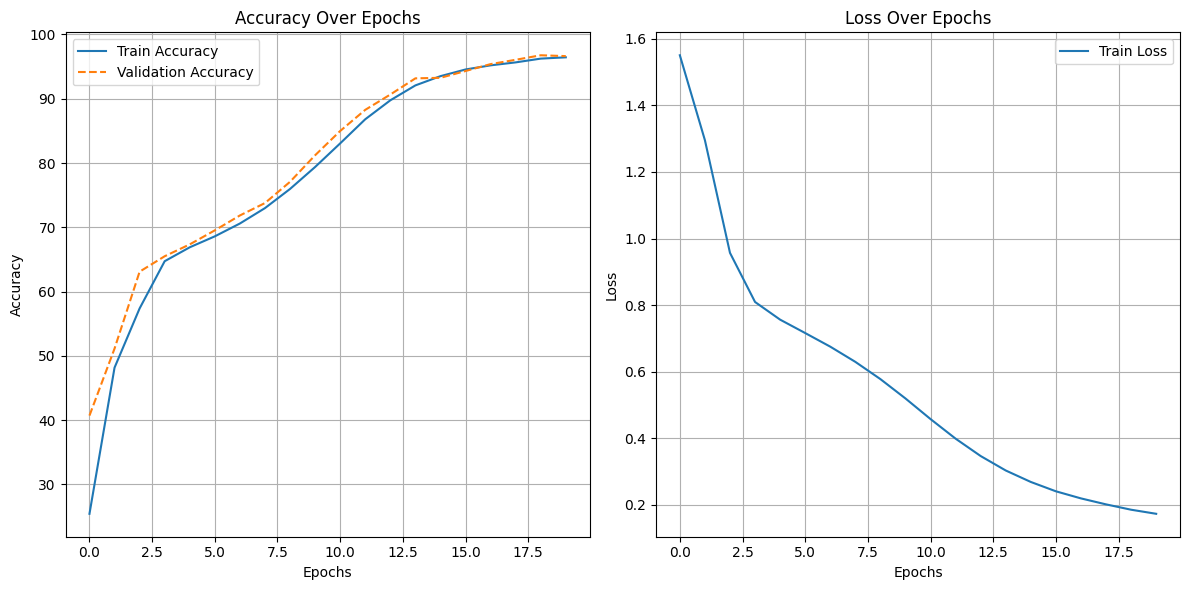

In [32]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for training and validation accuracies
ax1.plot(train_accuracies, label='Train Accuracy')
ax1.plot(val_accuracies, label='Validation Accuracy', linestyle='--')
ax1.set_title('Accuracy Over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot for training losses
ax2.plot(train_losses, label='Train Loss')
ax2.set_title('Loss Over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [33]:
model.eval()
correct = 0
total = 0
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 96.58%


test with single input as for inference

In [34]:
import torch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def load_single_input():
    # Step 1: Load the CSV file and select the first row for inference
    csv_file_path = 'depression_dataset copy.csv'  # Update with your actual file path
    data = pd.read_csv(csv_file_path)
    
    # Step 2: Process the data (drop 'target' and 'total_count' columns for inference)
    features = data.drop(['target', 'total_count'], axis=1)  # Adjust this if you have a target column
    single_input = features.values[0]  # Select the first row
    
    # Step 3: Preprocess the input (assuming you used MinMaxScaler during training)
    scaler = MinMaxScaler()
    # Fit scaler to the full dataset (assuming you're loading the full dataset)
    scaler.fit(features)  # Use full dataset for fitting the scaler
    scaled_input = scaler.transform([single_input])  # Scale the single input
    print("Single input after scaling:", scaled_input)

    return scaled_input

def run_inference(model):
    # Step 4: Prepare the input for inference
    scaled_input = load_single_input()

    # Convert the input to a PyTorch tensor
    input_tensor = torch.tensor(scaled_input, dtype=torch.float32)

    # Step 5: Make the prediction using the trained model
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get the predicted class

    print(f"Predicted class: {predicted.item()}")


# Assuming 'model' is your trained PyTorch model, you can now run inference
run_inference(model)


Single input after scaling: [[1.         1.         0.33333333 1.         1.         1.
  1.         1.         0.33333333 0.         1.         1.
  1.         1.         1.         1.         0.66666667 1.
  0.66666667 0.66666667 0.         1.         1.         1.
  1.         1.         1.         0.66666667 1.         0.33333333
  1.         1.         0.33333333 0.66666667 1.         1.
  0.         0.33333333 1.         0.66666667 1.         1.
  0.         0.66666667 1.         1.         1.         1.
  1.         0.66666667 0.         0.         0.33333333 1.
  0.5        1.         0.         0.         0.15384615 0.        ]]
Predicted class: 0


/home/brglt/Desktop/nillion/ETH-Online-mental-health/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [35]:

outputs= model(test_loader.dataset[0][0].unsqueeze(0))
print(outputs)
torch.argmax(outputs, axis=1)

tensor([[  8.3223, -19.5409,  -0.7499, -39.0664,   7.8246]],
       grad_fn=<AddmmBackward0>)


tensor([0])

In [36]:
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
print("precision: {:.3f}%".format(precision[1] * 100))
print("recall: {:.3f}%".format(recall[1] * 100))
print("f1: {:.3f}%".format(f1[1] * 100))
print("support: {}".format(support[1]))
print("accuracy: {}".format(epoch_accuracy)) # TODO check

precision: 92.686%
recall: 94.854%
f1: 93.757%
support: 855
accuracy: 96.44051342897207


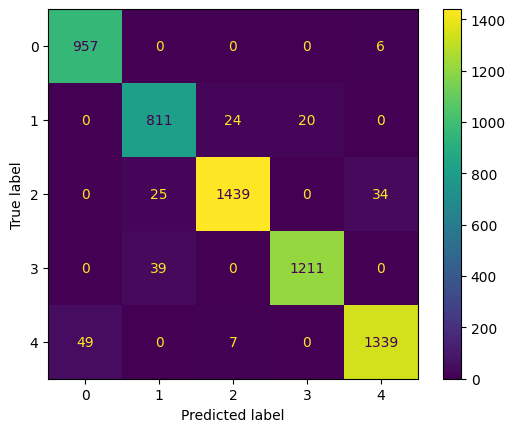

In [37]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), )
disp.plot()

## Model Provider flow

# Authenticate with Nillion

To connect to the Nillion network, we need to have a user key and a node key. These serve different purposes:

The `user_key` is the user's private key. The user key should never be shared publicly, as it unlocks access and permissions to secrets stored on the network.

The `node_key` is the node's private key which is run locally to connect to the network.

In [38]:
os.getcwd()

'/home/brglt/Desktop/nillion/ETH-Online-mental-health/nada_project'

In [39]:
# Load all Nillion network environment variables
os.getcwd()
assert os.getcwd().endswith(
    "nada_project"
), "Please run this script from the examples/multi_layer_perceptron directory otherwise, the rest of the tutorial may not work"
load_dotenv()
print(os.getenv("NILLION_CLUSTER_ID"))
dotenv_path = '/home/brglt/Desktop/nillion/ETH-Online-mental-health/nada_project/.env'
load_dotenv(dotenv_path)
print(os.getenv("NILLION_CLUSTER_ID"))

b13880d3-dde8-4a75-a171-8a1a9d985e6c
b13880d3-dde8-4a75-a171-8a1a9d985e6c


In [40]:
print(os.getenv("NILLION_CLUSTER_ID"))

b13880d3-dde8-4a75-a171-8a1a9d985e6c


In [41]:
print(os.getenv("NILLION_NILCHAIN_PRIVATE_KEY_0"))

75634f5625d535c2aea9580795ef617d85c7924ec8509dac806ddd4008773243


In [42]:
cluster_id = os.getenv("NILLION_CLUSTER_ID")
grpc_endpoint = os.getenv("NILLION_NILCHAIN_GRPC")
chain_id = os.getenv("NILLION_NILCHAIN_CHAIN_ID")
import random


# seed = str(random.randint(1, 1000))
seed = str(random.randint(1, 1000))
model_provider_userkey = UserKey.from_seed((seed))
model_provider_nodekey = NodeKey.from_seed((seed))
model_provider_client = create_nillion_client(model_provider_userkey, model_provider_nodekey)
model_provider_party_id = model_provider_client.party_id
model_provider_user_id = model_provider_client.user_id
model_provider_party_id

'12D3KooWBdJf83h24mkBhbKvRyU8h2zNZnCnkfWdrh4Q7MVBw77g'

In [1]:
!pynadac /home/brglt/Desktop/nillion/ETH-Online-mental-health/nada_project/src/mental_main.py

In [44]:
env_vars = {key: os.getenv(key) for key in os.environ.keys()}

# Print the environment variables
for key, value in env_vars.items():
    print(f'{key}: {value}')

CHROME_DESKTOP: code-url-handler.desktop
DBUS_SESSION_BUS_ADDRESS: unix:path=/run/user/1000/bus
DEBUGINFOD_URLS: https://debuginfod.ubuntu.com 
DESKTOP_SESSION: ubuntu
DISPLAY: :1
GDK_BACKEND: x11
GDMSESSION: ubuntu
GIO_LAUNCHED_DESKTOP_FILE: /usr/share/applications/code.desktop
GIO_LAUNCHED_DESKTOP_FILE_PID: 3649
GJS_DEBUG_OUTPUT: stderr
GJS_DEBUG_TOPICS: JS ERROR;JS LOG
GNOME_DESKTOP_SESSION_ID: this-is-deprecated
GNOME_SHELL_SESSION_MODE: ubuntu
GPG_AGENT_INFO: /run/user/1000/gnupg/S.gpg-agent:0:1
GSM_SKIP_SSH_AGENT_WORKAROUND: true
GTK_MODULES: gail:atk-bridge
HOME: /home/brglt
INVOCATION_ID: 896c15e013e946ed9eb0d2d2d41003fb
JOURNAL_STREAM: 8:15090
LANG: en_US.UTF-8
LESSCLOSE: /usr/bin/lesspipe %s %s
LESSOPEN: | /usr/bin/lesspipe %s
LOGNAME: brglt
MANAGERPID: 2317
MEMORY_PRESSURE_WATCH: /sys/fs/cgroup/user.slice/user-1000.slice/user@1000.service/session.slice/org.gnome.Shell@x11.service/memory.pressure
MEMORY_PRESSURE_WRITE: c29tZSAyMDAwMDAgMjAwMDAwMAA=
ORIGINAL_XDG_CURRENT_DESKTOP

In [45]:
cluster_id, grpc_endpoint, chain_id, model_provider_party_id

('b13880d3-dde8-4a75-a171-8a1a9d985e6c',
 '65.109.228.73:9090',
 'nillion-chain-testnet-1',
 '12D3KooWBdJf83h24mkBhbKvRyU8h2zNZnCnkfWdrh4Q7MVBw77g')

In [46]:
party_names = ["Provider", "User"]
program_name = "mental_main"
program_mir_path = f"{program_name}.nada.bin"

In [47]:
payments_config = create_payments_config(chain_id, grpc_endpoint)
payments_client = LedgerClient(payments_config)
payments_wallet = LocalWallet(
    PrivateKey(bytes.fromhex(os.getenv("NILLION_NILCHAIN_PRIVATE_KEY_0"))),
    prefix="nillion",
)

In [48]:
program_id = await store_program(
    model_provider_client,
    payments_wallet,
    payments_client,
    model_provider_user_id,
    cluster_id,
    program_name,
    program_mir_path,)

Getting quote for operation...
Submitting payment receipt 2 unil, tx hash FC9F466F2ED93698D38DE8814F28AF60506C970A68085F4D65650F137121CEFE
Stored program. action_id: 5u5hYMBa1VjozL74efbc91NiQE12MaLccKuBy5abYZ4uz3p4JHCJYW6XLQzvkD1N5NVm3ntmxf76UNzD9VLcVc7u/mental_main
Stored program_id: 5u5hYMBa1VjozL74efbc91NiQE12MaLccKuBy5abYZ4uz3p4JHCJYW6XLQzvkD1N5NVm3ntmxf76UNzD9VLcVc7u/mental_main


In [49]:
model_client = TorchClient(model)

In [53]:
model_secrets = nillion.NadaValues(
    model_client.export_state_as_secrets("mental_health_nn", na.SecretRational)
)
permissions = nillion.Permissions.default_for_user(model_provider_client.user_id)
permissions.add_compute_permissions({model_provider_client.user_id: {program_id}})

model_store_id = await store_secrets(
    model_provider_client,
    payments_wallet,
    payments_client,
    cluster_id,
    model_secrets,
    1,
    permissions,
)

Getting quote for operation...
Quote cost is 255458 unil
Submitting payment receipt 255458 unil, tx hash B8C652EB6CFAB2984B2284EFB3DEF491B3864AE9FE0DE7DFC81FA00AA5BCC09F


In [54]:
# This information is needed by the model user
with open("src/data/tmp.json", "w") as provider_variables_file:
    provider_variables = {
        "program_id": program_id,
        "model_store_id": model_store_id,
        "model_provider_party_id": model_provider_party_id,
    }
    json.dump(provider_variables, provider_variables_file)

In [55]:
torch.save(model.state_dict(), "src/data/my_model.pt")